In [71]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,      # reducing this for computational requirements
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [72]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.7.1
tensorflow version: 2.19.0


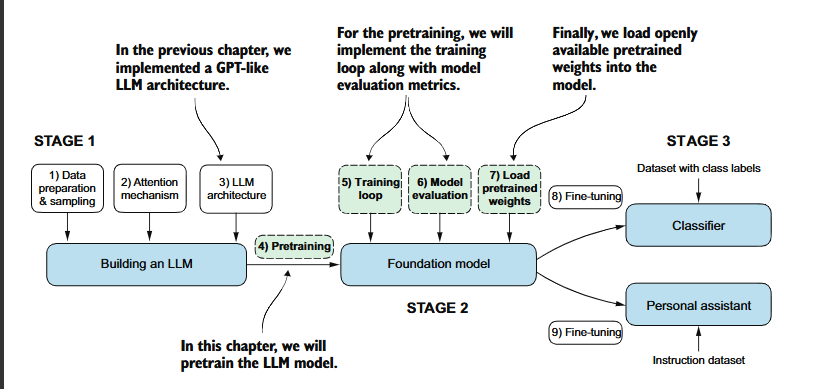

Initialize the GPT model from the previous chapters

In [73]:
import torch
import tiktoken
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [74]:
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids= []
        self.target_ids= []

        # tokenize the text
        token_ids= tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # dont store trillions of tokens like this
        
        # create the sliding window
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk= token_ids[i:i+max_length]
            target_chunk= token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [75]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle= True, drop_last=True, num_workers=0):
    
    # initialize the tokenizer
    tokenizer= tiktoken.get_encoding("gpt2")

    # create the dataset
    dataset= GPTDatasetV1(txt, tokenizer, max_length, stride)

    # create the dataloader
    dataloader= DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle,    
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [76]:
class MultiHeadAttentionClass(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias= False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out= d_out
        self.d_in= d_in
        self.num_heads= num_heads
        self.head_dim= d_out // num_heads # reduce the dimension of the output vector for each head
        
        self.W_query= torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key= torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value= torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj= torch.nn.Linear(d_out, d_out, bias=qkv_bias)
        self.dropout= torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))                # put one above and over the diagonal and rest 0


    def forward(self, x):
        b, num_tokens, d_in= x.shape

        keys= self.W_key(x)        # (2, 6, 3)-> (b, num_tokens, d_out)
        queries= self.W_query(x)
        values= self.W_value(x)

        # we now split the  matrix by adding a "num_heads" dimension
        # unroll last dim: (b, num_tokens, d_out)-> (b, nums_tokens, num_heads, head_dim)
        keys= keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries= queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values= values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose-> (batch, self.num_heads, self.num_tokens, self.head_dim)
        keys= keys.transpose(1, 2)
        queries= queries.transpose(1, 2)
        values= values.transpose(1, 2)

        attn_scores= queries @ keys.transpose(2,3)         # (b, num_heads, num_tokens, head_dim) @ (b, num_heads, head_dim, num_tokens)

        # original mask truncated to the number of tokens and converted to boolean
        mask_bool= self.mask.bool()[:num_tokens, :num_tokens]

        # use the mask to set the upper triangle of the attention scores to -inf
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights= torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights= self.dropout(attn_weights)

        # shape: (b, num_heads, num_tokens, head_dim)
        context_vec= (attn_weights @ values). transpose(1, 2)

        # combine the heads, where self.d_out= self.num_heads * self.head_dim
        context_vec= context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec= self.out_proj(context_vec)     # optional projecton

        return context_vec

In [77]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [78]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps= 1e-5
        self.scale= nn.Parameter(torch.ones(emb_dim))
        self.shift= nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean= x.mean(dim=-1, keepdim= True)
        var= x.var(dim= -1, keepdim= True, unbiased= False)
        norm_x= (x-mean)/ torch.sqrt(var+ self.eps)
        return self.scale * norm_x + self.shift

In [79]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers= nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),      # 768-> 3072
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),      # 3072-> 768  
        )
    
    def forward(self, x):
        return self.layers(x)


In [80]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttentionClass(
            d_in= cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length= cfg["context_length"],  
            dropout= cfg["drop_rate"],
            num_heads= cfg["n_heads"],  
            qkv_bias= cfg["qkv_bias"]
        )  
        self.ff= FeedForward(cfg)
        self.norm1= LayerNorm(cfg["emb_dim"])
        self.norm2= LayerNorm(cfg["emb_dim"])
        self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

    
    def forward(self, x):
        # shortcut connections for attention block
        shortcut= x
        x = self.norm1(x)
        x= self.att(x)
        x= self.drop_shortcut(x)
        x= x + shortcut         # add the original input back

        # shortcut connections for feed forward block
        shortcut= x
        x= self.norm2(x)
        x= self.ff(x)
        x= self.drop_shortcut(x)
        x= x + shortcut         # add the original input back

        return x

In [81]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb= nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb= nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb= nn.Dropout(cfg["drop_rate"])

        self.trf_blocks= nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm= LayerNorm(cfg["emb_dim"])
        self.out_head= nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias= False
        )

    def forward(self, in_idx):
        batch_size, seq_length= in_idx.shape
        tok_embeds= self.tok_emb(in_idx)
        pos_embeds= self.pos_emb(torch.arange(seq_length, device=in_idx.device))

        x= tok_embeds + pos_embeds
        x= self.drop_emb(x)

        x= self.trf_blocks(x)

        x= self.final_norm(x)

        logits= self.out_head(x)

        return logits

In [82]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        idx_cond= idx[:, -context_size:]    # truncate the input to the last context_size tokens

        with torch.no_grad():
            logits= model(idx_cond)

        # get the last token's logits
        logits= logits[:, -1, :]

        probas= torch.softmax(logits, dim= -1)

        # idx_next= torch.multinomial(probas, num_samples=1)  # sample from the distribution

        idx_next= torch.argmax(probas, dim=-1, keepdim=True)  # take the most probable token

        idx= torch.cat((idx, idx_next), dim=1)

    return idx

In [83]:
torch.manual_seed(123)
model= GPTModel(GPT_CONFIG_124M)
model.eval();

In [84]:
def text_to_token_ids(text, tokenizer):
    encoded= tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor= torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat= token_ids.squeeze(0).tolist()  # remove batch dimension
    return tokenizer.decode(flat)

# Example usage
tokenizer= tiktoken.get_encoding("gpt2")
start_context= "You live only"
token_ids= generate_text_simple(
    model= model,
    idx= text_to_token_ids(start_context, tokenizer),
    max_new_tokens= 7,
    context_size= GPT_CONFIG_124M["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

You live onlyaunt IdentityAME odor been absorbs prol


Calculating the loss function

logits-> probs-> target_probs-> log_probs-> average_log_probs-> negative_log_probs

* Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary
* Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [85]:

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [86]:
inputs.shape

torch.Size([2, 3])

In [87]:
with torch.no_grad():
    logits= model(inputs)

probs= torch.softmax(logits, dim= -1)   # prob of each token in vocab
probs.shape

torch.Size([2, 3, 50257])

apply the argmax function to convert the probability scores into predicted token IDs

In [88]:
predicted_ids= torch.argmax(probs, dim=-1)  # predicted token ids
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(predicted_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: gur repeating went


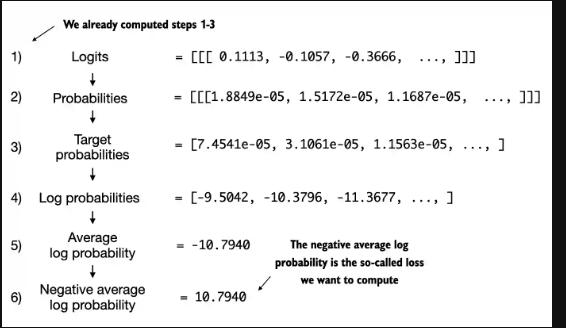

In [89]:
logits.shape, targets.shape

(torch.Size([2, 3, 50257]), torch.Size([2, 3]))

for the cross_entropy to implement we will flatten these tensors by combining them over the batch dimensions

In [90]:
logits_flat=logits.flatten(0,1)
targets_flat= targets.flatten()
logits_flat.shape, targets_flat.shape

(torch.Size([6, 50257]), torch.Size([6]))

The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [91]:
loss= torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"Loss: {loss.item()}")

Loss: 10.595633506774902


perplexity is also a concept of cross entropy
* simply the exponential of the cross_entropy loss
* it tells how unsure the model is

In [92]:
perplexity= torch.exp(loss)
print(f"Perplexity: {perplexity.item()}")
# is coming too high.. the model is untrained and very unsure

Perplexity: 39959.97265625


lets get our dataset on which we will be training our GPT model

In [93]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data= response.read().decode('utf-8')
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(text_data)
else:
    with open(file_path, 'r', encoding='utf-8') as f:
        text_data= f.read()

In [94]:
print(text_data[:70])

I HAD always thought Jack Gisburn rather a cheap genius--though a good


In [95]:
total_characters= len(text_data)
total_tokens= len(tokenizer.encode(text_data, allowed_special={"<|endoftext|>"}))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


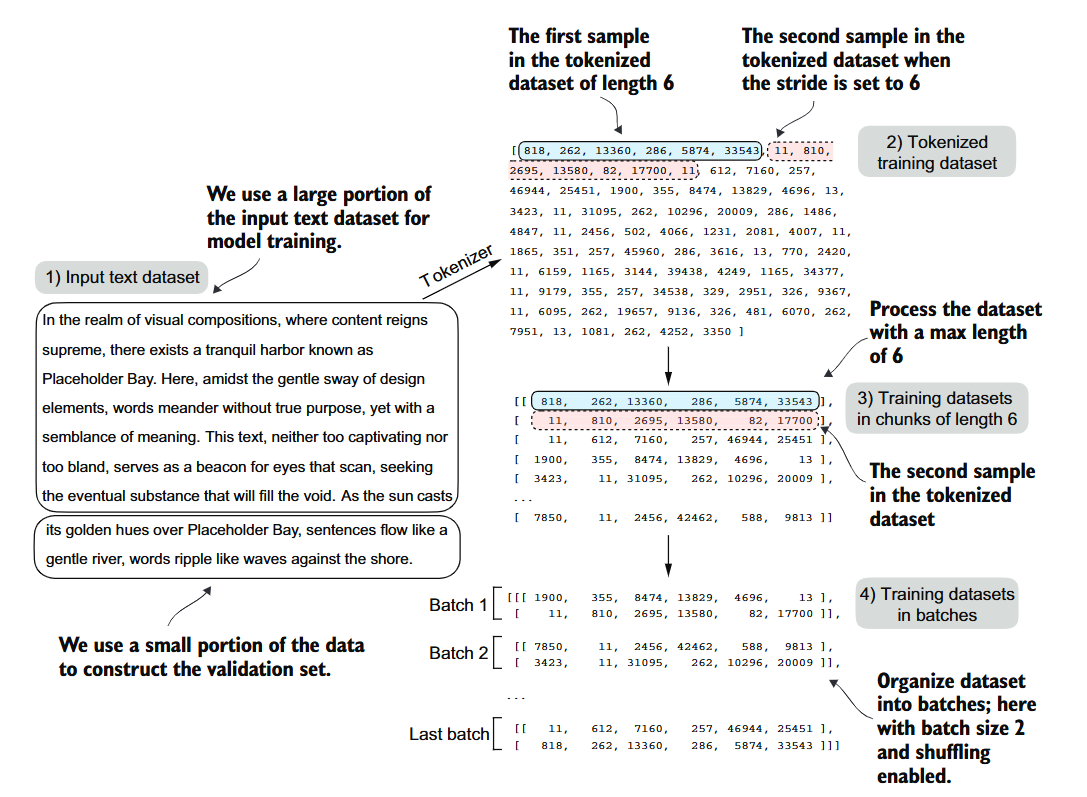

load the dataloader

In [96]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,      # reducing this for computational requirements
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [97]:
train_ratio= 0.9
split_indx= int(train_ratio* len(text_data))
train_data= text_data[:split_indx]
val_data= text_data[split_indx:]

train_dataloader= create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    num_workers=0,
    drop_last=True
)

val_dataloader= create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    num_workers=0,
    drop_last=False,
)

In [98]:
len(train_dataloader), len(val_dataloader)

(9, 1)

In [99]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [100]:

print("Train loader:")
for x, y in train_dataloader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_dataloader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


calculate the cross_entropy function

In [101]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch= input_batch.to(device), target_batch.to(device)
    logits= model(input_batch)
    logits_flat= logits.flatten(0,1)
    loss= torch.nn.functional.cross_entropy(logits_flat, target_batch.flatten())
    print("Train Batch Loss done")
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss= 0
    if len(data_loader)==0:
        print("Length of data_loader is 0. Returning NaN")
        return float("nan")
    elif num_batches is None:
        num_batches= len(data_loader)
    
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches= min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss= calc_loss_batch(input_batch, target_batch, model, device)
            total_loss+= loss.item()
        else:
            break
    return total_loss / num_batches          


In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [103]:
len(train_dataloader)

9

In [104]:
with torch.no_grad():
    train_loss= calc_loss_loader(train_dataloader, model= model,device= device)
    val_loss= calc_loss_loader(val_dataloader, model, device )
print(f"Train loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")

Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train loss: 10.9814
Validation loss: 10.9590


lets pretrain our model

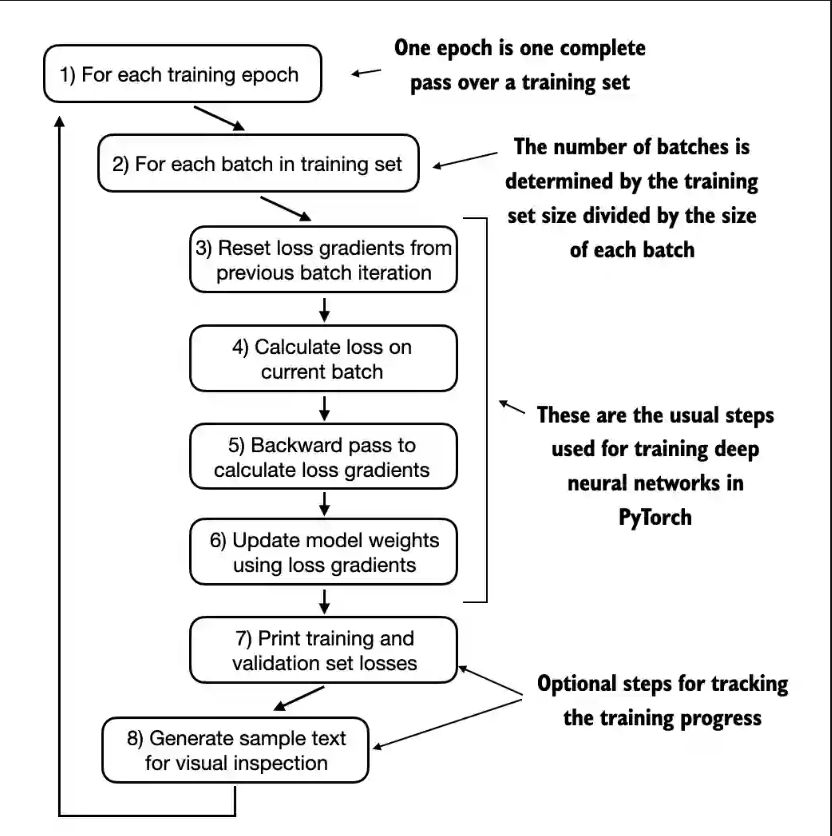

In [105]:
def train_model_simple( model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses,val_losses, track_tokens_seen= [], [], []
    tokens_seen, global_step=0,-1

    # main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()
            loss= calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()  # number of tokens in the batch
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq==0:
                train_loss, val_loss= evaluate_model(model, train_dataloader, val_dataloader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
            
            # generate and print sample after each epoch
        generate_and_print_sample(
        model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen



def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss= calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss= calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [106]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)


In [107]:
import torch.optim
from torch.optim import AdamW
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Ep 1 (Step 000000): Train loss 9.872, Val loss 10.030
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Ep 1 (Step 000005): Train loss 7.989, Val loss 8.278
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Ep 2 (Step 000010): Train loss 6.663, Val loss 7.029
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss done
Train Batch Loss do

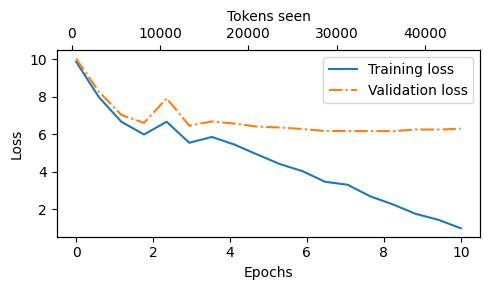

In [108]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

using the temperature scaling and top-k sampling

In [109]:
def generate(model, idx, max_new_tokens, context_size, temperature= 0.0, top_k=None, eos_id= None):

    # for loop same as before-> Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # truncate the input to the last context_size tokens
        with torch.no_grad():
            logits= model(idx_cond)
        logits= logits[:,-1,:]

        # New: Filter logits using top_k sampling
        if top_k is not None:
            # keep only top_k values
            top_logits, _= torch.topk(logits, top_k)        # also gives the indices of the top_k logits
            min_val= top_logits[:, -1]                      # get the minimum value of the top_k logits
            
            # put the -inf mask on the rest
            logits= torch.where(logits< min_val, torch.tensor(float("-inf")).to(logits.device), logits)


        # New: Apply temperature scaling
        if temperature >0.0:
            logits= logits/ temperature

            probs= torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # sample from the distribution
            idx_next= torch.multinomial(probs, num_samples= 1)

        else:
            idx_next= torch.argmax(logits, dim= -1, keepdim= True)

        if idx_next== eos_id:
            break

        idx= torch.cat((idx, idx_next), dim=1)      # (batch_size, num_tokens+1)

    return idx

In [110]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you had made through that he _ed by the fact that a across the first


loading and saving model weights in PyTorch

In [111]:
torch.save(model.state_dict(), "model.pth")

In [112]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [113]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [114]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

PreLoading the GPT weights

In [115]:
! pip install tqdm

In [ ]:
from ch06.gpt_download import download_and_load_gpt2

In [117]:
settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="gpt2",)


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 83.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 512kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 44.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [03:39<00:00, 2.26MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.61MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 309kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 300kiB/s]  


In [118]:
print("Settings", settings)
print("Parameter dictionary keys:", params.keys())

Settings {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [119]:
print(params["wte"])
print("Token Embedding Weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token Embedding Weight tensor dimensions: (50257, 768)


* Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance
* First, we initialize a new GPTModel instance
* Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too
* We are also using the 1024 token context length that was used by the original GPT-2 model(s)

In [120]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

The next task is to assign the OpenAI weights to the corresponding weight tensors in our GPTModel instance

In [121]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [122]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])
    
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
        
load_weights_into_gpt(gpt, params)
gpt.to(device);



In [124]:

torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Coffee has", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Coffee has not been an easy experience. You don't have full or partial support by your local government because they'll either try to deny
